# Дообучение модели "DeepPavlov/rubert-base-cased" на размеченных данных

### Сюда приходит файл __df_train_balanced.csv__

### Выбранная модель: DeepPavlov/rubert-base-cased.
* Решил взять небольшую BERT подобную модель, чтобы инференс был быстрым

In [1]:
!pip uninstall -y torch torchvision torchaudio fastai transformers datasets accelerate bitsandbytes peft

!pip install -q \
    "torch==2.3.0" \
    "torchvision==0.18.0" \
    "transformers==4.42.4" \
    "datasets==2.19.1" \
    "accelerate==0.31.0" \
    "bitsandbytes==0.43.1" \
    "peft==0.11.1" \
    "sentencepiece" \
    "protobuf<=3.20.3"

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
Found existing installation: datasets 3.6.0
Uninstalling datasets-3.6.0:
  Successfully uninstalled datasets-3.6.0
Found existing installation: accelerate 1.8.1
Uninstalling accelerate-1.8.1:
  Successfully uninstalled accelerate-1.8.1
Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
     ━━━

## Подготовка к генерации (Загрузка данных и модели)

In [6]:
import pandas as pd

In [13]:
df_balanced_train = pd.read_csv("/kaggle/input/traint-bank-sirius/df_balanced_train.csv")
df_balanced_train = df_balanced_train[['text', 'target']] #забываю сделать index=False 

In [14]:
df_balanced_train['target'].value_counts()
#уже получше

target
одежда                    915
нет товара                688
товары для детей          407
текстиль                  386
посуда                    382
обувь                     363
украшения и аксессуары    345
бытовая техника           345
электроника               341
Name: count, dtype: int64

## Обучение модели и оценка её качества

### Full-Fine-Tunning  модели cointegrated/rubert-base-cased

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch

In [15]:
df_balanced = df_balanced_train

# Создаем словари для перевода текстовых меток в числовые и обратно
categories = df_balanced['target'].unique().tolist()
categories.sort()
label2id = {label: i for i, label in enumerate(categories)}
id2label = {i: label for i, label in enumerate(categories)}
NUM_LABELS = len(categories)

df_balanced['label'] = df_balanced['target'].map(label2id)

train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['label']
)

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'label'],
        num_rows: 3337
    })
    validation: Dataset({
        features: ['text', 'target', 'label'],
        num_rows: 835
    })
})


In [82]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"

# згружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# загружаем модель для классификации отзывов
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

print('модель загружена')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


модель загружена


In [83]:
#Токенизизация датасета

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(["text", "target"])
tokenized_datasets.set_format("torch")

print(tokenized_datasets['train'][0])

Map:   0%|          | 0/3337 [00:00<?, ? examples/s]

Map:   0%|          | 0/835 [00:00<?, ? examples/s]

{'label': tensor(3), 'input_ids': tensor([   101,  29756,   2630,  96980,    106,    839,    845,  87702,    106,
         78185,  23521,    106,   2988,  12839,    130,  12940,    130,  12839,
         89940,  69461,    130,   7848,    128,   2739,   1469,  14406,   1469,
         20486,    132,  18946,  35334,    128,   2739,   1469,  20486,    132,
         78707,   1790,    861,  27132,    106, 115773,  52426,    106,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
      

In [85]:
from datasets import load_metric
import numpy as np
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

training_args = TrainingArguments(
    output_dir="./rubert_classifier_results",
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [86]:
# Создаем объект Trainer, передавая ему все компоненты: модель, данные, аргументы
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Запускаем дообучение
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,2.092200,1.811227,0.296304
2,1.454200,0.956227,0.737827
3,0.714900,0.505272,0.841247
4,0.338000,0.486190,0.853905
5,0.264100,0.557882,0.851172
6,0.165200,0.547301,0.859254
7,0.103000,0.624931,0.861811


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=735, training_loss=0.70095818415791, metrics={'train_runtime': 451.3015, 'train_samples_per_second': 51.759, 'train_steps_per_second': 1.629, 'total_flos': 1536599355008256.0, 'train_loss': 0.70095818415791, 'epoch': 7.0})

------
-----
#### CHECKPOINT SAVE MODEL

In [87]:
FINAL_MODEL_PATH = "/kaggle/working/final_rubert_classifier"

trainer.save_model(FINAL_MODEL_PATH)
tokenizer.save_pretrained(FINAL_MODEL_PATH)

print("лучшая модель сохранена")

лучшая модель сохранена


In [104]:
!du -sh /kaggle/working/final_rubert_classifier

684M	/kaggle/working/final_rubert_classifier


In [105]:
import shutil
shutil.make_archive("/kaggle/working/final_rubert_classifier", 'zip', "/kaggle/working/final_rubert_classifier")

'/kaggle/working/final_rubert_classifier.zip'

In [106]:
!curl -X POST -F "file=@/kaggle/working/final_rubert_classifier.zip" -F "keep=1" https://bashupload.com/



Uploaded 1 file, 660 968 995 bytes

wget https://bashupload.com/grLo1/1VtaA.zip




-----
-----

## Разметка тестового набора с замером скорости работы

In [90]:
from transformers import pipeline

#Загружаем дообученную модель
pipe = pipeline("text-classification", model=FINAL_MODEL_PATH)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [91]:
import time
import pandas as pd

X_test = pd.read_csv("/kaggle/input/traint-bank-sirius/X_test.csv")
X_test_text = X_test['text'].astype(str).tolist()

start_time = time.time()
results = pipe(X_test_text)
end_time = time.time()

total_time = end_time - start_time
num_samples = len(X_test_text)
avg_time_per_sample = total_time / num_samples

print(f"Обработано {num_samples} отзывов")
print(f"Общее время: {total_time:.4f} секунд")
print(f"Среднее время на один отзыв: {avg_time_per_sample:.6f} секунд ({avg_time_per_sample * 1000:.3f} мс)")

Обработано 7276 отзывов
Общее время: 470.8038 секунд
Среднее время на один отзыв: 0.064706 секунд (64.706 мс)


In [92]:
X_test_fully = pd.concat([
    X_test,           
    pd.DataFrame(results)                 
], axis=1)


In [93]:
predictions_test = pd.DataFrame({
    'target': X_test_fully['label']
})
X_test_fully.to_csv("/kaggle/working/X_test_fully_with_predictions.csv", index=False)
predictions_test.to_csv("/kaggle/working/predictions_test.csv", index=False)

In [94]:
X_test_fully

,text,label,score
0,Советую продавца,нет товара,0.992897
1,По вашему это платье???? Это узкая кофта !!!! ...,одежда,0.993120
2,Жуткая синтетика. Неприятная ткань. Летом не п...,нет товара,0.967457
3,"Джемперок так себе на хилую четверку,запах гол...",одежда,0.991472
4,"обычная х/б рубашка.не плотная,просвечивает ни...",одежда,0.994219
...,...,...,...
7271,"Все отлично, на ОГ 86, ОТ 70, ОБ 99 рост 160 ...",одежда,0.993602
7272,"так и не пришли, но деньги вернули!",нет товара,0.990113
7273,Рубашка маломерка. XL - по меркам соответствуе...,одежда,0.994293
7274,на картинке совсем другая кофта и модель и ткань,одежда,0.994012


In [95]:
predictions_test

,target
0,нет товара
1,одежда
2,нет товара
3,одежда
4,одежда
...,...
7271,одежда
7272,нет товара
7273,одежда
7274,одежда


In [98]:
submission_test = pd.DataFrame({
    'target': [r['label'] for r in results]
})
submission_test.to_csv("/kaggle/working/predictions_test.csv", index=False)

#### Получились довольно хорошие результаты.

In [102]:
reviews_to_classify = [
    "Эта клавиатура просто ужасна, клавиши залипают.",
    "Отличная кастрюля! Ничего не пригорает, очень довольна покупкой.",
    "Заказал ребенку конструктор, он в восторге",
    "Честно говоря немного узковато в плечах",    
    "Девушка выглядела так привлекательно в нем",
    "рубашка не пришла"
]

# Получаем предсказания
results = pipe(reviews_to_classify)
for review, result in zip(reviews_to_classify, results):
    print(f"Отзыв: '{review}'")
    print(f"-> Категория: '{result['label']}' (score: {result['score']:.4f})\n")

Отзыв: 'Эта клавиатура просто ужасна, клавиши залипают.'
-> Категория: 'электроника' (score: 0.9953)

Отзыв: 'Отличная кастрюля! Ничего не пригорает, очень довольна покупкой.'
-> Категория: 'посуда' (score: 0.9948)

Отзыв: 'Заказал ребенку конструктор, он в восторге'
-> Категория: 'товары для детей' (score: 0.9950)

Отзыв: 'Честно говоря немного узковато в плечах'
-> Категория: 'одежда' (score: 0.9923)

Отзыв: 'Девушка выглядела так привлекательно в нем'
-> Категория: 'одежда' (score: 0.4560)

Отзыв: 'рубашка не пришла'
-> Категория: 'одежда' (score: 0.9836)



По скорам можно увидеть, что чем легче пример, тем выше у модели уверенность в своем выборе 

In [50]:
import shutil
shutil.make_archive("/kaggle/working/final_rubert_classifier", 'zip', "/kaggle/working/final_rubert_classifier")
shutil.make_archive("/kaggle/working/rubert_classifier_results", 'zip', "/kaggle/working/rubert_classifier_results")

'/kaggle/working/rubert_classifier_results.zip'

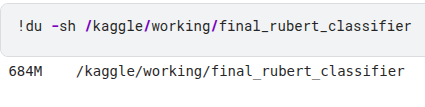
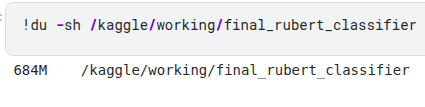
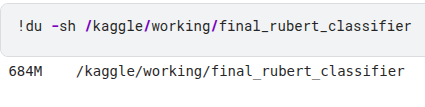

Итог: Получили модель которая имеет следующие показатели
* Скорость инференса: всего 0.064 сек/запрос
* Модель весит всего лишь 684 Мб
* имеет достаточно хорошее качество
* Модель хорошо справляется даже с нетривиальными отзывами, где нет названия товара а есть лишь какие-то признаки(описание), по которым можно определить категорию отзыва